In [7]:
import os
import pandas as pd
import numpy as np
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Set working directory here
WD = '/Users/johnmichael/Documents/vm-spinal-risk/vm-spinal-risk'

In [9]:
df = pd.read_csv(os.path.join(WD, 'data/all_risk_processed.csv'))

In [10]:
df['spin_surg'] = np.where(df['prior_surg'] == 0 & np.isnan(df['spin_surg']),
                           0, df['spin_surg'])
df['succ_surg'] = np.where(df['prior_surg'] == 0 & np.isnan(df['succ_surg']),
                           0, df['succ_surg'])

In [11]:
corr_df = df.filter(regex='odi_final|spinal_risk_score|age$|sex|height_m|weight_kg|ethni|income|educa|_surg|bmi|dospert_|ADI_').copy()
corr_df['ADI_NATRANK'] = pd.to_numeric(corr_df['ADI_NATRANK'], errors='coerce')
corr_df['ADI_STATERNK'] = pd.to_numeric(corr_df['ADI_STATERNK'], errors='coerce')
corr_df.dropna(inplace=True)

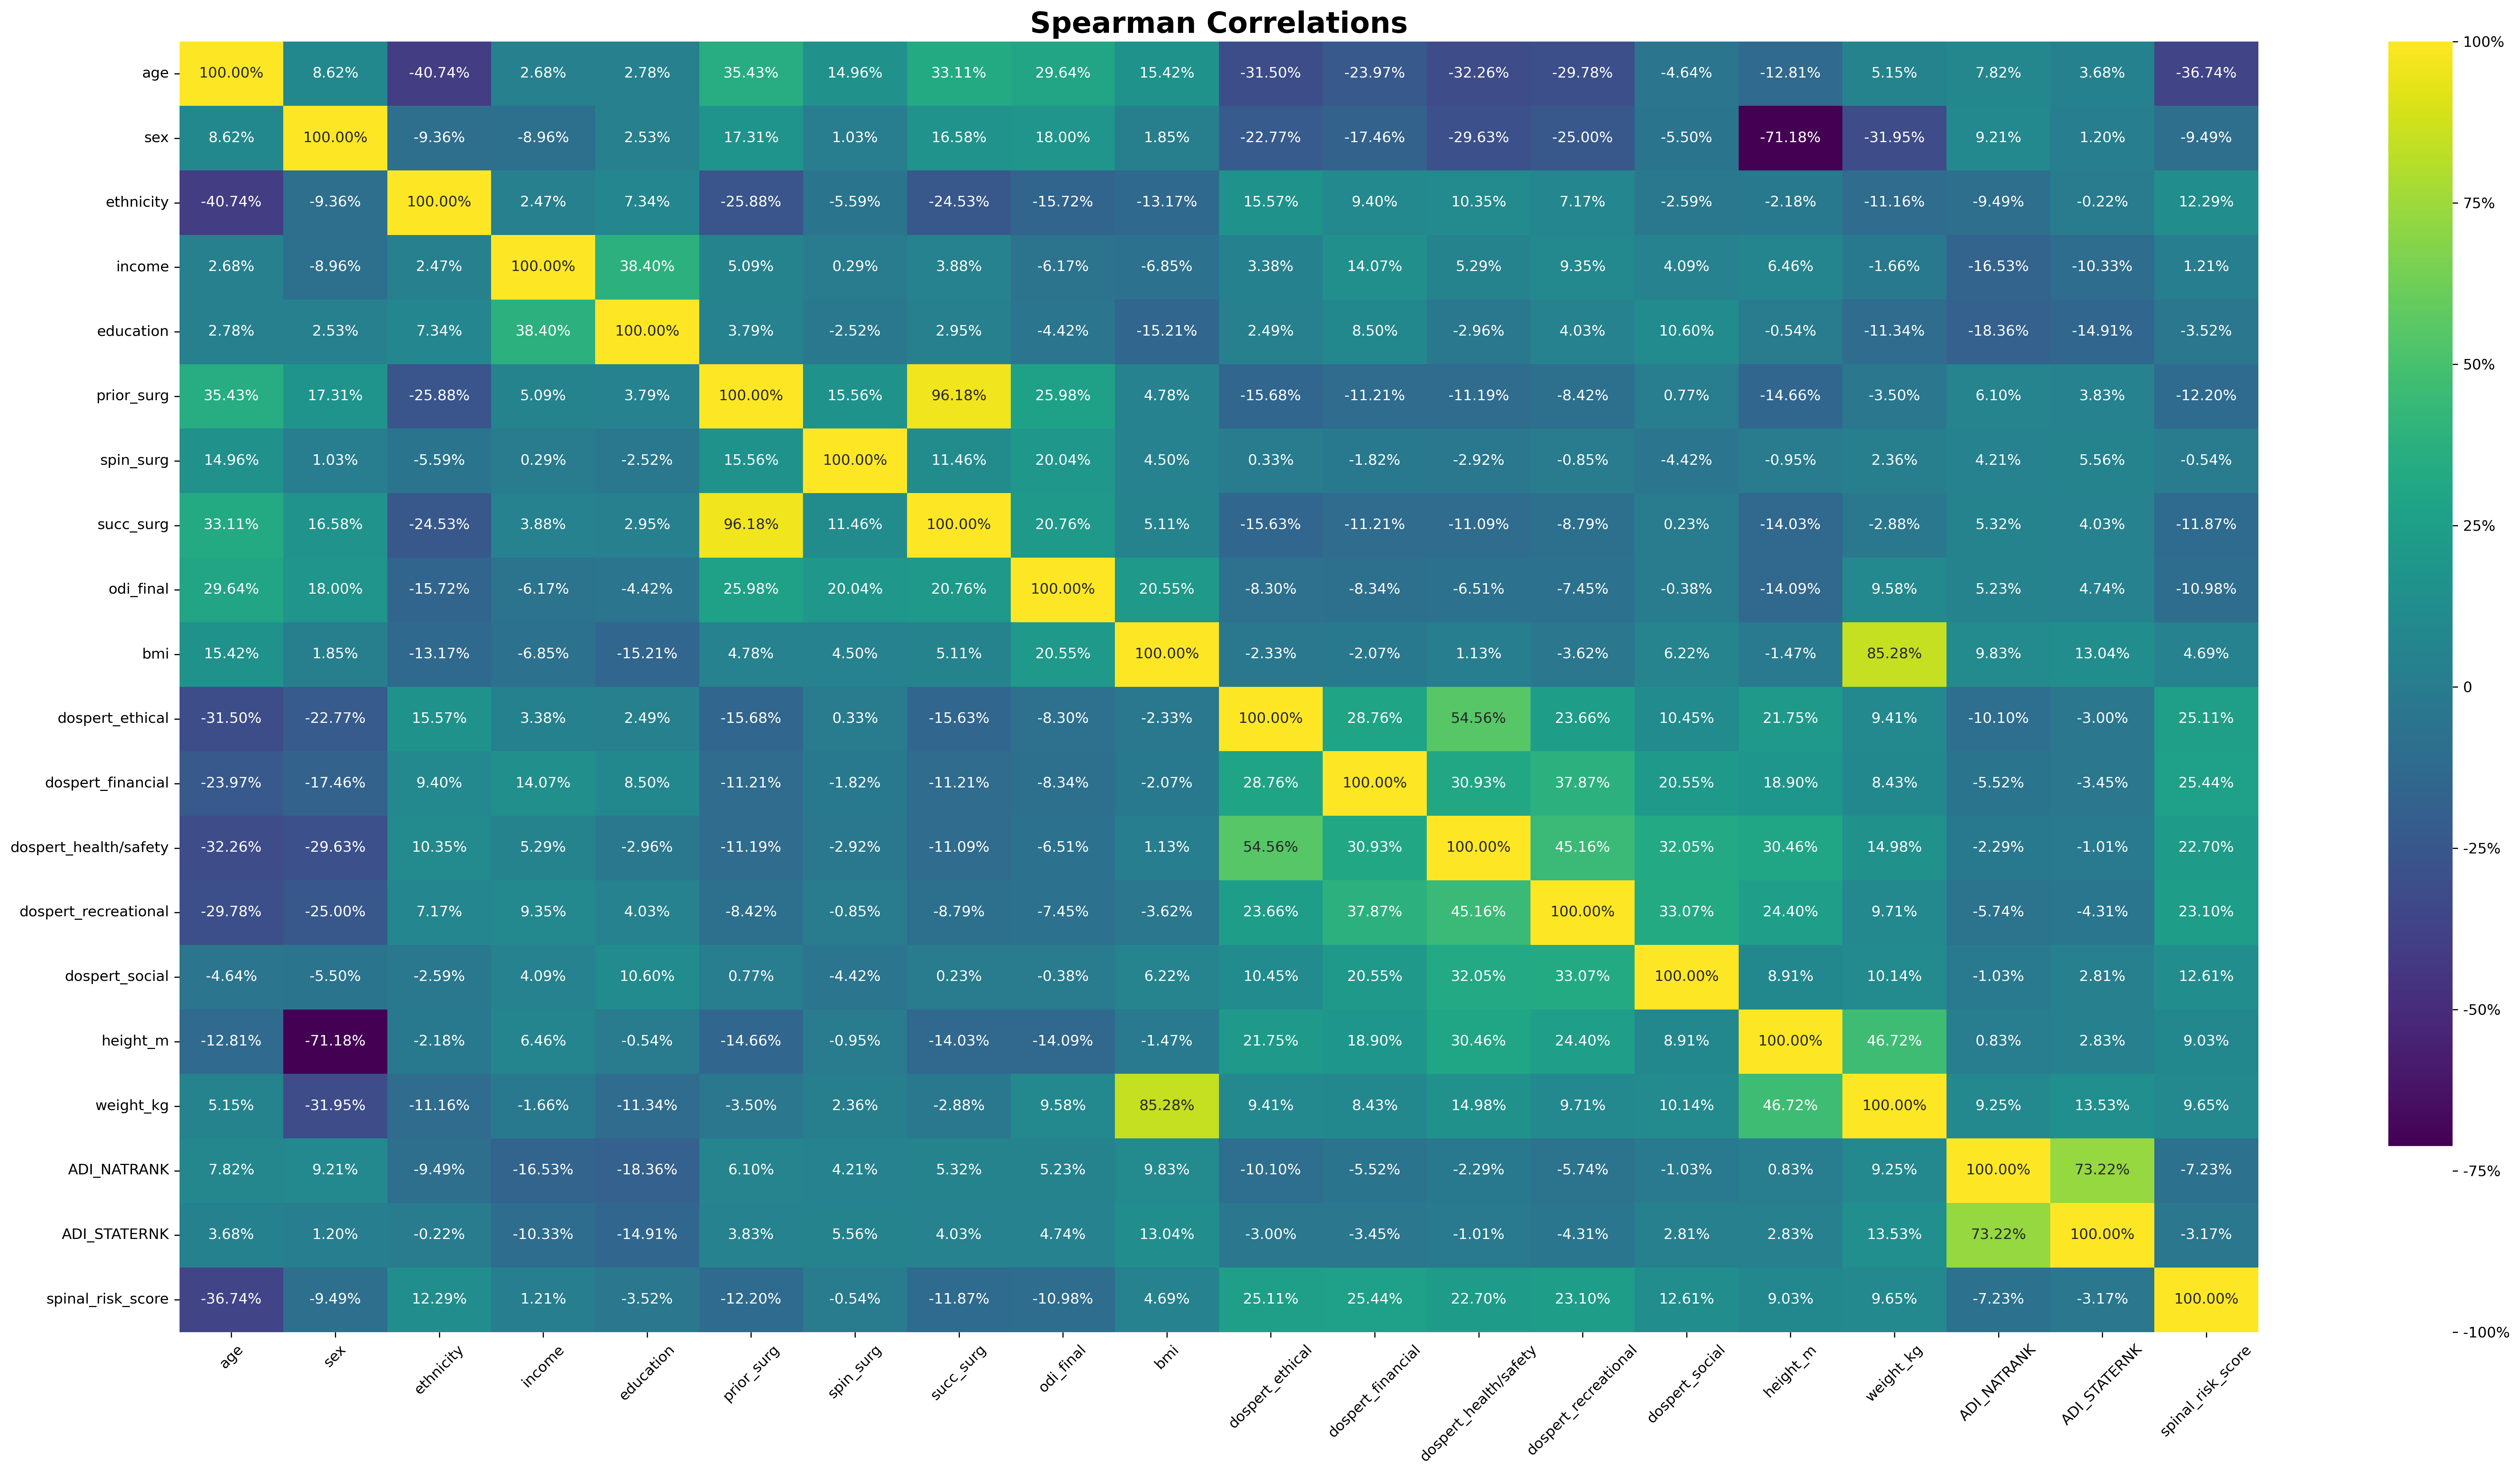

In [14]:
plt.figure(figsize=(32, 16), dpi=300)
ax = sns.heatmap(corr_df.corr(method='spearman'), annot=True, cmap='viridis', fmt='.2%')
plt.xticks(rotation=45)
plt.title('Spearman Correlations', fontsize=20, weight='bold')
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1, -.75, -.5, -.25, 0, .25, .5, .75, 1])
cbar.set_ticklabels(['-100%', '-75%', '-50%', '-25%', '0', '25%', '50%', '75%', '100%'])
plt.savefig(os.path.join(WD, 'figures/odi_risk_correlation.png'))

In [13]:
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data['feature'] = corr_df.columns 
  
# calculating VIF for each feature 
vif_data['vif'] = [variance_inflation_factor(corr_df.values, i) 
                   for i in range(len(corr_df.columns))]
vif_data.sort_values(by='vif', ascending=False, inplace=True)
vif_data

,feature,vif
9,bmi,176.023506
16,weight_kg,175.861874
15,height_m,111.118398
5,prior_surg,55.888460
7,succ_surg,50.664137
14,dospert_social,25.716268
19,spinal_risk_score,18.985989
1,sex,18.297418
4,education,16.342661
0,age,14.358530
